# Fire Image Classification

How well can we build a neural network to classify images of fire?

This is a binary classification problem. In this notebook we will use the Keras deep-learning API to explore the use of:

- Convolutional Neural Network Architecture
- Optimizing Neural Network Hyperparameters
- Upsampling the Minority Class in an unbalanced Dataset
- Augmenting the Images to Add Samples to the Dataset

Let's begin!

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Keras Imports
import tensorflow as tf
import keras
from keras import backend as K
# CNN and MLP architecture
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Dropout,
    Flatten,
    BatchNormalization
)
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import RandomNormal
# Keras Callbacks
from keras.callbacks import EarlyStopping, TensorBoard
# Time Training
import time
# Data Splitting
from sklearn.model_selection import train_test_split
# Image Preprocessing
from PIL import Image
from keras.preprocessing.image import img_to_array
# Optimizing Hyperparameters
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
# Data Generator
import util
# Loading Model from JSON file
from keras.models import model_from_json
# Resampling function
from sklearn.utils import resample
# Data Augmentation of the Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Get the Data

In [2]:
df = pd.read_csv('Fire-Detection-Image-Dataset/fires.csv')

In [3]:
df.head()

,Unnamed: 0,Folder,filename,label
0,0,Normal Images 3,Hotel_Monterey_La_Soeur_Osaka_standard_twin_be...,0
1,1,Normal Images 3,house5.jpg,0
2,2,Normal Images 3,mi-plage-hawai.jpg,0
3,3,Normal Images 3,JB224_03_Colourful_christmas_table_setting_in_...,0
4,4,Normal Images 3,Interior Design Ideas (3).jpg,0


In [4]:
# define predictor and target sets of data
features = [df.columns[1], df.columns[2]]
target = [df.columns[3]]
X, y = df[features], df[target]
# Store number of class
num_classes = 2

## Split DataFrame Based on Label

In [5]:
def split_data(df):
    """Split a DataFrame into training and testing sets.
       Up to 75% of data will be used for training, the 
       rest is randomly selected for testing.
    
       Parameters:
       df(pandas.DataFrame): overall dataset
       
       Return: tuple(DataFrame, DataFrame): 
                returns two DataFrame objects for 
                each subset of the data
    
    """
    # Split df into train and test, based on label
    # Credit goes to this Stack Overflow answer for the following:
    # https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
    selector = np.random.rand(len(df)) < 0.75
    df_train, df_test = df[selector], df[~selector]
    return df_train, df_test

def data():
    """Data providing function (will later use for Hyperas)."""
    df = pd.read_csv('Fire-Detection-Image-Dataset/fires.csv')
    selector = np.random.rand(len(df)) < 0.75
    df_train, df_test = df[selector], df[~selector]
    print(f"Number of Training Samples: {len(df_train)}")
    print(f"Number of Testing Samples: {len(df_test)}")
    return df_train, df_test

df_train, df_test = data()

Number of Training Samples: 480
Number of Testing Samples: 171


## Defining the Optimal Model 

### Build a Generator

For this dataset, we'll increase the efficiency of training by loading in subsections of the dataset to train on at a time, using Python-esque generator in Keras!

In [6]:
# data_gen = util.data_gen
def data_gen(df_gen, batch_size):
    """Generate batches of the dataset to train the model on, one subsection at a time.
       Credit goes to Milad Toutounchian for this implementation, originally found at:
       https://github.com/Make-School-Courses/DS-2.2-Deep-Learning/blob/master/Final_Project/image_data_prep.ipynb
    
       Parameters:
       df(DataFrame): larger portion of the datset used for training
       batch_size(int): the number of samples to include in each batch
       
       Returns:
       tuple: input features of the batch, along with corresponding labels
    
    """
    while True:
        # list of images
        x_batch = np.zeros((batch_size, 1024, 1024, 3))
        # list of labels
        y_batch = np.zeros((batch_size, 1))
        # add samples until we reach batch size
        for j in range(len(df_gen) // batch_size):
            batch_index = 0
            for index in df_gen['Unnamed: 0']:
                if batch_index < batch_size:
                    # add image to the input
                    filepath = f"Fire-Detection-Image-Dataset/{df_gen['Folder'][index]}/{df_gen['filename'][index]}"
                    img = Image.open(filepath)
                    image_red = img.resize((1024, 1024))
                    x_batch[batch_index] = img_to_array(image_red)
                    # set label
                    y_batch[batch_index] = df_gen['label'][index]
                    # increment index in the batch
                    batch_index += 1
            yield (x_batch, y_batch)

### Finding the Best Architecture

Now we'll find the optimal number of layers and neurons per layer using TensorBoard.

To begin, it's time to define some **utility functions** that will make the rest of this analysis less redundant.

In [3]:
# Helper functions to Reduce Repetition
def add_conv_layer(model, layer_size, needs_input):
    """Add a Keras convolutional layer to the model, along with MaxPooling.
       Will specify input shape as well if needed.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       need_input(bool): signals if the convolutional layer needs to specify
                         the dimensions of the input
       
       Returns: None
       
    """
    if needs_input is True:
        # specify input dimension for 1st conv layer
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(1024, 1024, 3))

    else:
        # otherwise all other convolutional layers don't need it
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu')
    # add Convolutional layer
    model.add(conv_layer)  
    # add MaxPooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  # no learning params
    return None
                  
    
def add_dense_layer(model, layer_size, is_output, drop_rate):
    """Add a multi-layer perceptron to the model
       Will specify 'sigmoid' for the final layer.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       is_output(bdool): signals if the MLP is the last layer
       drop_rate(float): percentage of connections in Dense layer
                       to cut off
       
       Returns: None
       
    """
    # specify activation function
    activation = 'relu' if is_output is False else 'sigmoid'
    # add MLP
    model.add(Dense(layer_size, activation=activation)) 
    # Add Dropout layer and Batch Normalization
    if is_output is False:
        model.add(BatchNormalization())
        model.add(Dropout(drop_rate))
    return None

def compile_model(model):
    """Compile the neural network.
    
       Parameter:
       model(keras.Sequential or keras.Model): the model object
       
       Returns: None
       
    """
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])
    return None

def define_model(units, conv_layers, dense_layers, dropout):
    """Define a CNN + MLP model in Keras.
    
       Parameters:
       units(int): number of neurons to go in a layer
       conv_layers(int): number of convolutional layers
       dense_layers(int): number of MLP
       dropout(float): percentage of connections in Dense layer
                       to cut off
                       
       Returns: tf.keras.Sequential: the neural network to train
    
    """
    # Instaniate model
    model = Sequential()
    # Add CNN layers
    add_conv_layer(model, units, True)
    for l in range(conv_layers - 1):
        # add convolutional layers that come after the 1st
        add_conv_layer(model, units, False)
    # Flatten the data
    model.add(Flatten())
    # Add MLP Layers
    for l in range(dense_layers - 1):
        add_dense_layer(model, units, False, dropout)
    # add final MLP, for output
    add_dense_layer(model, 1, True, dropout)
    # Compile Model
    compile_model(model)
    return model


def train_model(model, df_training,
                df_testing, epochs, 
                batch_size, callbacks,
                steps_per_epoch=None,
                val_steps=None):
    """Train the Keras model using a generator and callback functions.
       
       Parameters:
       model(keras.Sequential or keras.Model): the model object
       df_training(pd.DataFrame): subsection of the dataset for training
       df_testing(pd.DataFrame): subsection of the dataset for testing
       epochs(int): number of forward and back passes for the entire
                    dataset through the model
       batch_size(int): number of samples the model trains on in one 
                        batch (small subsection of the training data)
       callbacks(List<function>): special Keras functions to improve models
       
       returns: History.history: a dict containing metrics about model
       
    """
    # train the model
    history = model.fit_generator(generator=data_gen(df_training, batch_size=batch_size),
                                steps_per_epoch=len(df_training['label']) // batch_size,
                                epochs=epochs,
                                validation_data=data_gen(df_testing, batch_size=batch_size),
                                validation_steps=len(df_testing['label']) // batch_size, 
                                callbacks=callbacks)
    return history

In [8]:
# Choices for the Model Architecture - values arbitrary
dense_layers = [1, 2, 3]
layer_sizes = [4, 8, 16]
conv_layers = [1, 2, 3]

# try different combinations!
# These for loops come from https://youtu.be/lV09_8432VA
for dense_layer in dense_layers:
    for size in layer_sizes:
        for conv in conv_layers:
            # name the combo
            NAME = (
                f'{conv}-conv-{size}-nodes' +
                f'-{dense_layer}-dense_layers' + 
                f'-{int(time.time())}'
            )
            # Instantiate TensorBoard to visualize model performance
            tensorboard = TensorBoard(log_dir=f'./Graph/{NAME}')
            # Define Model
            model = define_model(size, conv, dense_layer, 0.2)
            # Train the Model (using a generator!)
            epochs, batch_size = 5, 20
            history = train_model(model, df_train, df_test, epochs, 
                                  batch_size, [tensorboard])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5
 1/24 [>.............................] - ETA: 1:44 - loss: 128.9514 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

**Final Conclusion: What's the Best Architecture for the Model?**

After training the different combinations above and looking through the [logs](Graph/) returned by Tensorboard, the best model archtecture has been determined to be:

- 3 Conv2D Layers
- 1 Dense Layer
- 4 Neurons in each Layer
- Dropout Rate of 20%
- 5 epochs
- 20 samples per Batch

This model had the following metrics, which was the best of any of the other models:

- Validation Accuracy: 100%
- Validation Loss: 4.51e31%
- Validation Precision: 96.25%
- Validation Recall: 95.09%
- F1-Score: 0.9567

Although the accuracy of 100% is a little concerning, it may be possible to prevent overfitting by increase the drop out rate to 30%.

###  Finding Optimal Hyperparameters

Now, we'll find the optimal values for the hyperparameters using hyperas...


In [10]:
def optimize_model():
    """Returns a dictionary with the results of the best model."""
    # define known parameters
    layer_size = 4
    # Instaniate model
    model = Sequential()
    # Instantiate TensorBoard to visualize model performance
    tensorboard = TensorBoard(log_dir='./Graph')
    # Add 3 CNN layers
    model.add(Conv2D(layer_size, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(1024, 1024, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(layer_size,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(layer_size,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Flatten the data
    model.add(Flatten())
    # Add 1 MLP Layer
    model.add(Dense(1, activation={{choice(['sigmoid', 'relu'])}}))
    # Compile Model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=
                      {{choice(
                          [keras.optimizers.Adadelta(),
                          'sgd', 'adam', 'rmsprop']   
                           )}},
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])
    # Train Model   
    batch_size={{choice([10, 20, 40])}}
    history = model.fit_generator(generator=util.data_gen(df_train, batch_size=batch_size),
                                steps_per_epoch=len(df_train['label']) // batch_size,
                                epochs={{choice([3, 5, 7])}},
                                validation_data=util.data_gen(df_test, batch_size=batch_size),
                                validation_steps=len(df_test['label']) // batch_size, 
                                callbacks=[tensorboard])
    
    # Get Optimized results
    # get the highest validation metrics of the training epochs
    val_loss = np.amax(result.history['val_loss'])
    print(f'Best validation acc of epoch: {(1-val_loss)}')
    return {
        'loss': val_loss,
        'accuracy': 1-val_loss,
        'status': STATUS_OK,
        'model': model
    }

# find the best model!
best_run, best_model = optim.minimize(model=optimize_model,
                                    data=data,
                                    algo=tpe.suggest,
                                    max_evals=5,
                                    trials=Trials(),
                                    notebook_name='classifications')
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, BatchNormalization
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from keras.optimizers import SGD
except:
    pass

try:
    from keras.initializers import RandomNormal
except:
    pass

try:
    from keras.callbacks import EarlyStopping, TensorBoard
except:
    pass

try:
    import time
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from PIL import Image
except

KeyboardInterrupt: 

**Final Conclusion: What are the Optimal Hyperparameters?**

After using Hyperas, the best hyperparameters appear to be the following (in order to balance model performance with overfitting and efficiency):

- Activation Function (for the output layer): Sigmoid
- Batch Size: 40
- Epochs: 3
- Optimizer: Adam

### Train, Summarize, and Save the Model

This will help us for future reference, so when we want to make more improvements to the model we can simply load it from a file.

In [4]:
optimal_model = load_model('model_weights', 'model_architecture')
print(optimal_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1022, 1022, 4)     112       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 511, 511, 4)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 509, 509, 4)       148       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 252, 252, 4)       148       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 126, 126, 4)       0         
______________________________________

### Save Model

We will define functions for both saving and loading the model (weights as well as architecture) from and Hadoop and JSON-formatted data.

The name of the files the model will be saved to shall be: 

- 'model_weights.h5' (Hadoop format)
- 'model_architecture.json' (Javascript Object Notation)

In [2]:
def save_model(model, weights_file, architecture_file):
    """Save the model weights and architecture.
    
       Parameters: 
       model(Model): keras Model object being saved
       weights_file(str): name of the Hadoop file where
                          weights will be saved
       architecture_file(str): name of the JSON file where 
                               model architecture is to be
                               saved
                               
       Returns: None
       
    """
    # Save the weights
    model.save_weights(f'{weights_file}.h5')
    # Save the architecture
    with open(f'{architecture_file}.json', 'w') as f:
        f.write(model.to_json())
    return None


def load_model(weights_file, architecture_file):
    """Read in the model weights and architecture.
    
       Parameters:
       weights_file(str): name of the Hadoop file where
                          weights loaded from
       architecture_file(str): name of the JSON file where 
                               model architecture is read from
                               
       Returns: keras.Model: new model instantiated using the 
                             information from the files
       
    """  
    # Load Architecture
    with open(f'{architecture_file}.json', 'r') as f:
        new_model = model_from_json(f.read())
    # Load Weights
    new_model.load_weights(f'{weights_file}.h5')
    return new_model

In [20]:
# Save the model
save_model(optimal_model, 'model_weights', 'model_architecture')

## Upsampling the Minority Class

We need more fire!

The majority of images in this dataset are currently for the "No fire" class. Therefore our model is now biased towards predicting this class, which makes its accuracy less reliable. 

In order to deal with this problem, we'll randomly duplicate some of the existing fire images in our dataset, such that the ratio of both is more balanced.

Look at [this blog post](https://elitedatascience.com/imbalanced-classes?_ga=2.44533796.1624997989.1593199508-1623274989.1547664151) for more info about this concept.

In [13]:
# Separate the DataFrame by classes
df_no_fire = df[df['label'] == 0]
df_fire = df[df['label'] == 1]
# Upsampling by replacement:
df_fire_upsampled = (
    resample(df_fire, replace=True,
             n_samples=len(df_no_fire), 
             random_state=123) # reproducible results
)
# Combine classes once more into one DataFrame
df_upsampled = pd.concat([df_no_fire, df_fire_upsampled])
# Verify class ratio is now 1:1
df_upsampled['label'].value_counts()

1    541
0    541
Name: label, dtype: int64

Now, let's retrain the model!

In [15]:
# load the model saved previously
prev_biased_model = load_model('model_weights', 'model_architecture')
# compile the model
compile_model(prev_biased_model)
# train-test split the data
df_train, df_test = split_data(df_upsampled)
# Retrain the model
history = train_model(prev_biased_model, df_train, df_test, epochs=3, 
                       batch_size=40, callbacks=[tensorboard])


Epoch 1/3


KeyboardInterrupt: 

In [27]:
# Checkpoint: Save the model again to make life easier!
save_model(prev_biased_model, 'model_weights', 'model_architecture')

## Data Augumentation

Let's add more variation to the dataset now, in order to make the model more robust!

Specifically, I will be using the code from this [lesson in DS 2.2](https://github.com/Make-School-Courses/DS-2.2-Deep-Learning/blob/master/Lessons/KerasforLargeDatasets.md) in order to generate new images of fire/no fire that may have the following alterations to them:

- different positions of the fire, or other objects
- different camera angles
- weird lighting

This will better prepare the model to be used on noisy, real world data in production!

In [16]:
# define certain parameters for training
image_dim = (1024, 1024)
batch_size = 40
dataset_dir = 'Fire-Detection-Image-Dataset'

# Instantiate training ImageDataGenerator from Keras
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Instantiate testing ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for the new images
train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=image_dim,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        dataset_dir,
        target_size=image_dim,
        batch_size=batch_size,
        class_mode='binary')

Found 651 images belonging to 6 classes.
Found 651 images belonging to 6 classes.


In [17]:
# Load the model saved previously
prev_no_aug_model = load_model('model_weights', 'model_architecture')
# Compile the model
compile_model(prev_no_aug_model)
# Train the model on augmented images, increased steps per epoch and validation steps
history = prev_no_aug_model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=800)

history = train_model(optimal_model, df_train, df_test, epoch=3, 
                       batch_size=40, callbacks=[tensorboard])

Epoch 1/3


KeyboardInterrupt: 

In [13]:
# Checkpoint: Save the model again to make life easier!
save_model(prev_no_aug_model, 'model_weights', 'model_architecture')

## Model Evaluation

Overall, how well did our model perform? In this section we will evaluate by understanding the following metrics, for how well the model classified validation data:

- Accuracy
- Precision
- Recall
- F1-Score

We will begin by loading in the model again, and compiling as well as training it such that it outputs accuracy, loss, precision, recall, and F1-Score.

In [ ]:
# load the model
model = load_model('model_weights', 'model_architecture')

In [ ]:
# compile model
# train model with callbacks, get history

In [ ]:
# get predictions
# calculate f1-score

Now, let's verify the metrics we have available to us for plotting, in the `history` object returned by the training above (with augmented data).

In [14]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'loss', 'accuracy', 'precision', 'recall'])


### Plotting Function

In [15]:
def plot_metric(metric):
    """Plots the model performance metric for training
       testing data using Matplotlib.
       
       Parameters
       metric(str): the name of the metric. Will be one of 
                    the keys in the History object, e.g. 'loss'
       
       Returns: None
       
    """
    # plot for training data
    plt.plot(history.history[metric])
    # plot for testing data
    val_form = f'val_{metric}'
    plt.plot(history.history[val_form])
    # add meta-info about graph - title, labels, legend
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # show the graph
    plt.show()
    return None

### Accuracy

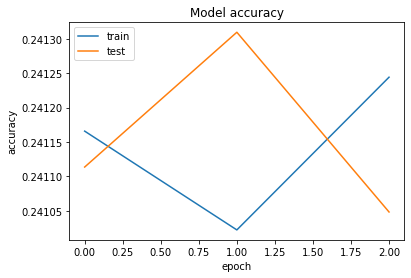

In [16]:
plot_metric('accuracy')

### Loss

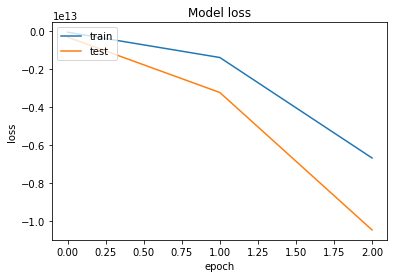

In [19]:
plot_metric('loss')

### Precision

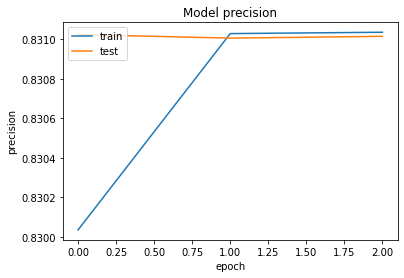

In [20]:
plot_metric('precision')

### Recall

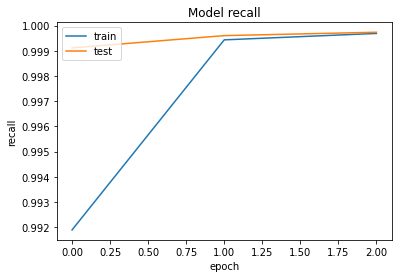

In [21]:
plot_metric('recall')

### F1-Score
```
F1-Score = (2 * Precision * Recall) / (Precision + Recall)
```
This value below is an approximate answer, using estimated values for validation precision and recall from the graphs above.

In [58]:
def f1_score(precision, recall):
    """Return the F1-Score.
    
       Parameters:
       precision(float): a proportion of the model's accurate positive predictions,
                         out of all the positive predictions made by said model
       recall(float): a proportion of the model's accurate positive predictions,
                      to all the samples which were truly positive (TP and FN)
                    
       Returns: float: the F1-Score is a function of both precision and recall,
                which especially becomes useful in datasets with unequal
                distribution of classes
    
    """
    return (2 * precision * recall) / (precision + recall)

f1 = f1_score(0.831, 0.999)
print(f'F1-Score of the Optimized Model: {round(f1, 3)}')

F1-Score of the Optimized Model: 0.907


## Final Conclusions

Ultimately, the model constructed had a validation accuracy of approximately 24.1% - this is bewildering, as the model still managed to score about 83.1% on validation precision, 99.9% on validation recall, and 0.907 for the F1-Score. This would suggest that the model is classifying both the minority and majority classes alright. 

To take this analysis further, I would train the model again and experiment in using early stopping callback functions to stop training once the accuracy stopped improving. Also, I would implement a function that could be used to exactly compute the F1-Score, and pass it in to the model compilation step.